In [53]:
import netket as nk
import numpy as np
import time
import json
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import flax
import pprint

In [54]:
SITES    = 8    # 4, 8, 16, 20 ... number of vertices in a tile determines the tile shape 
JEXCH1   = .4     # nn interaction
JEXCH2   = 1     # nnn interaction
#USE_MSR  = True  # should we use a Marshall sign rule?
TOTAL_SZ = None
# output file name
OUT_NAME = "SS-tiles"


In [55]:
if SITES == 64:
    indent = [0,0,0,0,0,0,0,0]
    width = [8,8,8,8,8,8,8,8]
    right_shift = 0
    bottom_shift = 0
elif SITES == 36:
    indent = [0,0,0,0,0,0]
    width = [6,6,6,6,6,6]
    right_shift = 0
    bottom_shift = 0
elif SITES == 20: #tile shape definition
    indent = [3,1,0,1,1,2]
    width = [1,4,5,5,4,1]
    right_shift = 2 #vertical shift of the center of (top) right tile (in the upward direction)
    bottom_shift = 4 #horizontal shift of the center of bottom (left) tile (in the left direction)
elif SITES == 16:
    indent = [0,0,0,0]
    width = [4,4,4,4]
    right_shift = 0
    bottom_shift = 0
elif SITES == 8:
    indent = [1,0,1]
    width = [2,4,2]
    right_shift = 2
    bottom_shift = 2
elif SITES == 4:
    indent = [0,0]
    width = [2,2]
    right_shift = 0
    bottom_shift = 0
else:
    raise Exception("Invalid number of sites given.")
N = sum(width) #number of nodes

deg45 = True # special case when angle of tiling is 45 deg
i = 0
while deg45 and i < len(width)-1:
    deg45 = (width[i] == width[i+1] + 2 or width[i] == width[i+1] - 2)
    i += 1
vertical_gap = False # is there a 1-site-sized gap between bottom (left) tile and left (top) tile ? 
horizontal_gap = False # is there a 1-site-sized gap between bottom (left) tile and bottom right tile ?
if deg45:
    if width[i]%2 == 0:
        vertical_gap = True
    else:
        horizontal_gap = True
        Exception("Not implemented ERROR during lattice definition. Please rotate given lattice by 90 degrees. This special case happens only when dealing with 45 deg tilings.")

left_shift = len(width) - right_shift + vertical_gap #vertical shift of the center of (top) left tile (in the upward direction)


# i j-->
# | .   .   .   0  
# V .   1   2   3   4
#   5   6   7   8   9
#   .   10  11  12  13  14
#   .   15  16  17  18
#   .   .   19

def getRandomNumber(): #returns a random integer
    return 4
def position(node): #returns positional indices i,j of the node
    row, n = 0, 0
    while n+width[row] <= node:
        n += width[row]
        row += 1
    column = indent[row] + node - n 
    return row, column
def index_n(row, column): #returns index n given positional indices
    return sum(width[0:row]) + column - indent[row]
def is_last(node):
    row, column = position(node)
    return (column == width[row] + indent[row] - 1)
def is_first(node):
    row, column = position(node)
    return (column == indent[row])
def is_lowest(node):
    row, column = position(node)
    if row == len(width) - 1:
        return True
    else:
        row += 1
        if column >= indent[row] and column < indent[row] + width[row]:
            return False
        else:
            return True
def rt(node): #returns index n of right neighbour
    if is_last(node):
        new_row = (position(node)[0] + right_shift)%(len(width)+vertical_gap)
        if new_row == len(width): # special case of gap
            new_row -= right_shift
        return sum(width[0:new_row])
    else:
        return (node+1)%N
def lft(node): #returns index n of left neighbour
    if is_first(node):
        new_row = (position(node)[0] + left_shift)%(len(width)+vertical_gap)
        if new_row == len(width):
            new_row -= left_shift
        return sum(width[0:new_row])+width[new_row]-1
    else:
        return (node-1)%N
def bot(node): #returns index n of bottom neighbour
    row, column = position(node)
    if is_lowest(node):
        no_of_columns = np.array(width)+np.array(indent)
        new_column = (column + bottom_shift)%max(no_of_columns)
        new_row = 0
        while new_column >= no_of_columns[new_row] or new_column < indent[new_row]:
            new_row += 1
        return index_n(new_row,new_column)
    else:
        return (node + width[row] + indent[row] - indent[row+1])
def lrt(node):
    return rt(bot(node))
def llft(node):
    return lft(bot(node))
#def dimer_partner(node): #retunrs the index of the site which has J_2 bond with given node (partner in always unique in SS model)
#    row, column = position(node)
#    return TODO

# Define custom graph
edge_colors = []
for node in range(N):
    edge_colors.append([node,rt(node), 1]) #horizontal connections
    edge_colors.append([node,bot(node), 1]) #vertical connections
    row, column = position(node)
    if column%2 == 0:
        if row%2 == 0:
            edge_colors.append([node,lrt(node),2])
        else:
            edge_colors.append([node,llft(node),2])


# Define the netket graph object
g = nk.graph.Graph(edges=edge_colors)

hilbert = nk.hilbert.Spin(s=.5, N=g.n_nodes, total_sz=TOTAL_SZ)


#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz)) #=sz*sz
#Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]]) #=sx*sx+sy*sy = 1/2*(sp*sm+sm*sp)
full_spin = mszsz+exchange # = S*S = sx*sx + sy*sy + sz*sz
bond_color = [1, 2, 1, 2]

## Magnetization order parameter (AF phase)
We define magnetization order parameter <font color=#d0312d> POZOR! můj spin $\hat{\bm{S}}$ je definovaný jako dvojnásobek typické definice $\hat{\bm{S}} \leftarrow 2\hat{\bm{S}}$ </font>
$$m_s^2 := \frac{1}{M^{2}} \sum_{i,j} {\rm e}^{i \bm{q}\cdot \bm{r}} \langle\hat{\bm{S}}_i \cdot \hat{\bm{S}}_j\rangle$$
where $M = L\cdot L$ (in case of Sandvik: $M = 2L\cdot L$ and $\hat{\bm{S}} = \frac{1}{2}\hat{\bm{S}}$). In our case $\bm{q} = (\pi,\pi)$.

Využíváme také identitu $\sigma^x_i\sigma^x_j+\sigma^y_i\sigma^y_j \equiv {2}\left(\sigma^+_i\sigma^-_j + \sigma^-_i\sigma^+_j\right)$


In [56]:
def SS_old(i,j): # S_i * S_j
    return 2*nk.operator.spin.sigmap(hilbert,i,dtype="float64")@nk.operator.spin.sigmam(hilbert,j,dtype="float64")+2*nk.operator.spin.sigmam(hilbert,i,dtype="float64")@nk.operator.spin.sigmap(hilbert,j,dtype="float64")+nk.operator.spin.sigmaz(hilbert,i,dtype="float64")@nk.operator.spin.sigmaz(hilbert,j,dtype="float64")
    #return nk.operator.spin.sigmax(hilbert, i)@nk.operator.spin.sigmax(hilbert, j) + nk.operator.spin.sigmay(hilbert, i)@nk.operator.spin.sigmay(hilbert, j) + nk.operator.spin.sigmaz(hilbert, i)@nk.operator.spin.sigmaz(hilbert, j)

def SS(i,j): #different method of definition
    if i==j:
        return nk.operator.LocalOperator(hilbert,operators=[[3,0],[0,3]],acting_on=[i])
    else:
        return nk.operator.LocalOperator(hilbert,operators=(mszsz+exchange),acting_on=[i,j])

def m_sSquared_slow(state):
    ss_operator = 0
    M = hilbert.size
    m_s2 = 0
    for i in range(M):
        for j in range(M):
            ss_operator += SS(i,j) * (-1)**np.sum(position(i)+position(j))
        if i%3==2 or i==(M-1):
            print(i)
            m_s2 += (state.transpose()@(ss_operator@state))[0,0]
            ss_operator = 0
    m_s2 = m_s2/M**2
    return m_s2

def m_sSquared(state):
    ss_operator = 0
    M = hilbert.size
    if M == 20: # we need to slower the calculation due to unkown reasons (prehaps numpy can't handle too non-sparse matrix) 
        return m_sSquared_slow(state)
    for i in range(M):
        for j in range(M):
            ss_operator += SS(i,j) * (-1)**np.sum(position(i)+position(j)) #(i+j) #chyba?
    m_s2 = (state.transpose()@(ss_operator@state))[0,0]/M**2
    return m_s2


## Dimer order parameter (DS phase)
$$m_{\rm dimer}^2 := -\frac{1}{3} \frac{2}{M} \sum_{(ij)_{dimer}} \langle\hat{\bm{S}}_i \cdot \hat{\bm{S}}_j\rangle$$
plus normalizace na 3/4 (v mém případě 3)

In [57]:
def m_dimer(state):
    ss_operator = 0
    M = hilbert.size
    for node in range(M):
        row, column = position(node)
        if column%2 == 0:
            if row%2 == 0:
                ss_operator += SS(node,lrt(node))
            else:
                ss_operator += SS(node,llft(node))
    m_d2 = -1/3 * (state.transpose()@(ss_operator@state))[0,0]/M*2
    return m_d2

## Plaquette order parameter (PS phase)
We define another order parameter $m_p := \langle \hat{\bm{Q}}_{\bm{R}} - \hat{\bm{Q}}_{\bm{R'}}\rangle$, where $\hat{\bm{Q}}_{\bm{r}} := \frac{1}{2}\left(\hat{\bm{P}}_{\bm{r}} + \hat{\bm{P}}_{\bm{r}}^{-1}\right)$, where $\hat{\bm{P}}_{\bm{r}} = \hat{\bm{P}}_{ijkl}^\text{cykl}$ is cyclic permutation operator 
$$\hat{\bm{P}}_{ijkl}^\text{cykl} | \dots \sigma_i \sigma_j \sigma_k \sigma_l \dots \rangle = | \dots \sigma_l \sigma_i \sigma_j \sigma_k \dots \rangle $$
We can implement cyclic permutation using binary permutation operator
$$ \hat{\bm{P}}^\text{cykl}_{ijkl} = \hat{\bm{P}}_{ik}\hat{\bm{P}}_{kl}\hat{\bm{P}}_{ij} \quad \quad \quad \left(\hat{\bm{P}}^\text{cykl}_{ijkl}\right)^{-1} = \hat{\bm{P}}_{jl}\hat{\bm{P}}_{kl}\hat{\bm{P}}_{ij}$$
And use a formula for permutation operator
$$ \hat{\bm{P}}_{ij} \equiv \frac{1}{2} (\hat{\bm{S}}_i\cdot \hat{\bm{S}}_j + \hat{\mathbb{1}})$$

In [58]:
def P(i,j): # two particle permutation operator
    return .5*(SS(i,j)+nk.operator.LocalOperator(hilbert,operators=[[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],acting_on=[i,j]))

def P_cykl(i,j,k,l): # 4 particle cyclic permutation operator
    return P(i,k)@P(k,l)@P(i,j)
def P_cykl_inv(i,j,k,l): # inverse of 4 particle cyclic permutation operator
    return P(j,l)@P(k,l)@P(i,j)

def P_r(i): # cyclic permutation of 4 sites located at position i
    return P_cykl(i,rt(i),lrt(i),bot(i))
# i --> i j  .... we assigne a lrt cell to each index i
#       l k
def P_r_inv(i): # inverse of cyclic permutation of 4 sites located at position i
    return P_cykl_inv(i,rt(i),lrt(i),bot(i))

def Q_r(i):
    return .5*(P_r(i) + P_r_inv(i))

def m_p_nearest(state):
    return state.transpose()@((Q_r(0)-Q_r(1))@state)

def m_p_diag(state):
    i = 0
    while sum(position(i))%2 == 0: # ensure that the plaquette is 'empty' (without J_2 bond inside)
        i += 1
    return state.transpose()@((Q_r(i)-Q_r(lrt(i)))@state)

## General structure factor

$$s(\bm{k}) := \frac{1}{M} \sum_{i,j} {\rm e}^{-i \bm{k}\cdot (\bm{r}_i - \bm{r}_j)} \langle\hat{\bm{S}}_i \cdot \hat{\bm{S}}_j\rangle$$


## general spin structure factor
$$ S(\bm{q}) := \frac{1}{M^{2}} \sum_{ij} {\rm e}^{i \bm{q}\cdot (\bm{r}_i - \bm{r}_j)} \langle\hat{\bm{S}}_i \cdot \hat{\bm{S}}_j\rangle$$
where $q_{x,y} = 2\pi \frac{n_{x,y}}{\sqrt{M}}$ for $n_{x,y} = \{0,\dots,\sqrt{M}-1\}$

In [59]:
def structure_factor(state,k):
    s_op = 0
    M = hilbert.size
    L = np.sqrt(M)
    k = 2*np.pi/L*np.array(k)
    if M >= 20: # we need to slower the calculation due to unkown reasons (prehaps numpy can't handle too non-sparse matrix) 
        raise Exception("structure_factor in not optimised for large hilbert spaces")
    if L != int(L):
        raise Exception("structure_factor not defined for non-square lattices")
    for i in range(M):
        for j in range(M):
            s_op += SS(i,j) * np.exp(-1j*np.sum(k*(np.array(position(i))-position(j)))) #(i+j) #chyba?
    structure_factor = (state.transpose()@(s_op@state))/M**2
    return structure_factor

In [1]:
# TODO

# Actual calculation

In [63]:
print("#N =", N)
print("# J1     J2      m_d2            m_p            m_s2             ground          1.excited          2.excited")
for JEXCH1 in np.arange(0.6,0.7,step=0.01):    #default: 0,1.2,step=0.2
    bond_operator = [
        (JEXCH1 * mszsz).tolist(),
        (JEXCH2 * mszsz).tolist(),
        (JEXCH1 * exchange).tolist(), # minus in case of MSR
        (JEXCH2 * exchange).tolist(),
    ]
    # Custom Hamiltonian operator
    ha = nk.operator.GraphOperator(hilbert, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)

    if g.n_nodes < 25:
        start = time.time()
        evals, eigvects = nk.exact.lanczos_ed(ha, k=3, compute_eigenvectors=True) #.lanczos_ed
        ground_state = eigvects.T[0]
        # print("time:", time.time() - start)
        m_d2 = m_dimer(eigvects[:,:1])
        # print("time:", time.time() - start)
        mp = m_p_diag(eigvects[:,:1])
        # print("time:", time.time() - start)
        m_s2 = m_sSquared(eigvects[:,:1])
        # print(structure_factor(ground_state,(2,2)))
        # print("time:", time.time() - start)
        #diag_time = time.time() - start
        #print("Ground state energy:",exact_ground_energy, "\nIt took ", round(diag_time,2), "s =", round((diag_time)/60,2),"min")
    else:
        print("System is too large for exact diagonalization. Setting exact_ground_energy = 0 (which is wrong)")
        exact_ground_energy = 0
    print("%.3f   %.3f  %2.10f   %2.10f   %.10f   %2.10f   %14.10f   %14.10f" % (JEXCH1, JEXCH2, m_d2, mp[0,0], m_s2, evals[0], evals[1], evals[2]))
    #print('{:>3}   {:>3}  {:>12}   {:>12}   {:>12}   {:>12}   {:>14}   {:>14}'.format(JEXCH1, JEXCH2, m_d2, mp[0,0], m_s2, evals[0], evals[1], evals[2]))

#N = 8
# J1     J2      m_d2            m_p            m_s2             ground          1.excited          2.excited
0.600   1.000  1.0000000000   -0.0000000000   0.0000000000   -12.0000000000   -10.4000000000    -8.8000000000
0.610   1.000  1.0000000000   -0.0000000000   -0.0000000000   -12.0000000000   -10.6400000000    -8.8800000000
0.620   1.000  1.0000000000   0.0000000000   -0.0000000000   -12.0000000000   -10.8800000000    -8.9600000000
0.630   1.000  1.0000000000   0.0000000000   -0.0000000000   -12.0000000000   -11.1200000000    -9.0400000000
0.640   1.000  1.0000000000   -0.0000000000   -0.0000000000   -12.0000000000   -11.3600000000    -9.1200000000
0.650   1.000  1.0000000000   -0.0000000000   0.0000000000   -12.0000000000   -11.6000000000    -9.2000000000
0.660   1.000  1.0000000000   -0.0000000000   0.0000000000   -12.0000000000   -11.8400000000    -9.2800000000
0.670   1.000  -0.3333333333   -0.0000000000   1.5000000000   -12.0800000000   -12.0000000000    -9.4000000000


## Spin structure factor visualization

In [62]:
L = 4
Lp = L+1
s = np.zeros((Lp,Lp))
for ky in range(Lp):
    for kx in range(Lp):
        s[ky,kx] = structure_factor(ground_state,(kx,ky))
        if kx == 0:
            print(ky)


Exception: structure_factor not defined for non-square lattices

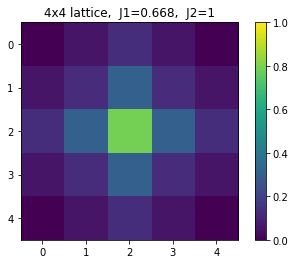

In [ ]:
plt.imshow(s,vmin=0,vmax=1)#, interpolation='spline16')
plt.title("4x4 lattice,  J1="+str(JEXCH1)+",  J2="+str(JEXCH2))
plt.colorbar()

In [ ]:
import seabasdforn as sns
ax = sns.heatmap(s)
plt.show()

ModuleNotFoundError: No module named 'seabasdforn'

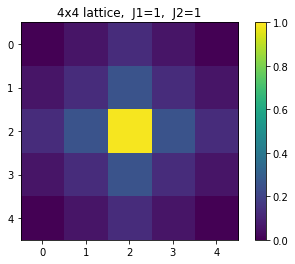

In [ ]:
plt.imshow(s,vmin=0,vmax=1)#, interpolation='spline16')
plt.title("4x4 lattice,  J1="+str(JEXCH1)+",  J2="+str(JEXCH2))
plt.colorbar()

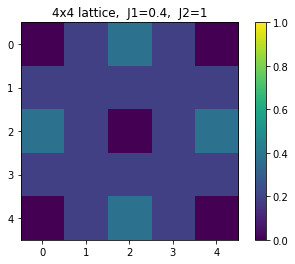

In [ ]:
plt.imshow(s,vmin=0,vmax=1)#, interpolation='spline16')
plt.title("4x4 lattice,  J1="+str(JEXCH1)+",  J2="+str(JEXCH2))
plt.colorbar()